In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import math
import keras

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy.stats import f_oneway

import warnings
warnings.filterwarnings('ignore')

data_path = 'og_data/'

train = pd.read_csv(os.path.join(data_path, 'train.csv'), parse_dates=['date'])
test = pd.read_csv(os.path.join(data_path, 'test.csv'), parse_dates=['date'])

# holidays_events = pd.read_csv(os.path.join(data_path, 'holidays_events.csv'), parse_dates=['date'])
oil = pd.read_csv(os.path.join(data_path, 'oil.csv'), parse_dates=['date'])
stores = pd.read_csv(os.path.join(data_path, 'stores.csv'))
transactions = pd.read_csv(os.path.join(data_path, 'transactions.csv'), parse_dates=['date'])
submission = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'), index_col='id')

2024-07-31 12:01:57.602152: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 12:01:57.609476: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-31 12:01:57.675738: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-31 12:01:57.730968: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 12:01:57.786548: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

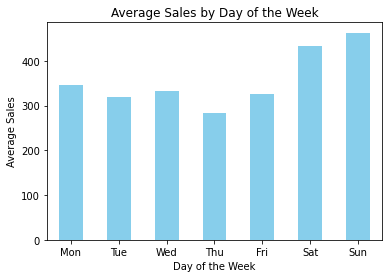

F-statistic: 1506.5585637191425
P-value: 0.0


In [2]:

data = pd.read_csv(os.path.join(data_path, 'train.csv'), parse_dates=['date'])

data['dayofweek'] = data['date'].dt.dayofweek

average_sales = data.groupby('dayofweek')['sales'].mean()

average_sales.plot(kind='bar', color='skyblue')
plt.title('Average Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Sales')
plt.xticks(range(0, 7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.show()

grouped = data.groupby('dayofweek')['sales']

sales_data = [group for name, group in grouped]

f_stat, p_value = f_oneway(*sales_data)
print('F-statistic:', f_stat)
print('P-value:', p_value)

In [3]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

In [4]:
date_min, date_max = train.date.min(), test.date.max()
oil['date'] = pd.to_datetime(oil['date'])
new_df = pd.DataFrame()
new_df['date'] = pd.date_range(date_min, date_max)
new_df = pd.merge(new_df,oil, how="outer", on='date')
new_df['dcoilwtico'] = new_df['dcoilwtico'].interpolate(method = "linear")
oil = new_df

oil_prices = np.asarray(oil['dcoilwtico'])
nans, x= nan_helper(oil_prices)
oil_prices[nans]= np.interp(x(nans), x(~nans), oil_prices[~nans])
oil['dcoilwtico'] = oil_prices

In [32]:
train_data = train.copy().drop(['onpromotion'], axis=1)
test_data = test.copy().drop(['onpromotion'], axis=1)

train_data['dayofweek'] = data['date'].dt.dayofweek
test_data['dayofweek'] = data['date'].dt.dayofweek

train_data = train_data.merge(oil, on='date', how='left')
test_data = test_data.merge(oil, on='date', how='left')



# Ordinal Encoding for 'family' column
ordinal_encoder = OrdinalEncoder(dtype=int)
train_data[['family']] = ordinal_encoder.fit_transform(train_data[['family']])
test_data[['family']] = ordinal_encoder.transform(test_data[['family']])

num_days_train = train["date"].nunique()
num_stores_train = train["store_nbr"].nunique()
num_families_train = train["family"].nunique()

num_days_test = test["date"].nunique()
num_stores_test = test["store_nbr"].nunique()
num_families_test = test["family"].nunique()

pivoted_train = train_data.pivot(index=['date','dcoilwtico','dayofweek'], columns=['store_nbr', 'family'], values='sales')

train_samples = int(num_days_train * 0.95)
train_samples_df = pivoted_train[:train_samples]
valid_samples_df = pivoted_train[train_samples:]

print("\nFirst 5 rows of the original train data:")
print(train_samples_df.shape)
print(train_samples_df.head())

minmax_scaler = MinMaxScaler()
minmax_scaler.fit(train_samples_df)
scaled_train_samples = minmax_scaler.transform(train_samples_df)
scaled_validation_samples = minmax_scaler.transform(valid_samples_df)

print("\nFirst 5 rows of the original train data:")
print(scaled_train_samples.shape)
print(scaled_train_samples)


First 5 rows of the original train data:
(1599, 1782)
store_nbr                          1                                       \
family                            0    1    2       3    4        5    6    
date       dcoilwtico dayofweek                                             
2013-01-01 93.140000  1          0.0  0.0  0.0     0.0  0.0    0.000  0.0   
2013-01-02 93.140000  2          2.0  0.0  2.0  1091.0  0.0  470.652  0.0   
2013-01-03 92.970000  3          3.0  0.0  0.0   919.0  0.0  310.655  0.0   
2013-01-04 93.120000  4          3.0  0.0  3.0   953.0  0.0  198.366  0.0   
2013-01-05 93.146667  5          5.0  0.0  3.0  1160.0  0.0  301.057  0.0   

store_nbr                                                ...    9           \
family                               7      8        9   ...   23       24   
date       dcoilwtico dayofweek                          ...                 
2013-01-01 93.140000  1             0.0    0.0    0.000  ...  0.0    0.000   
2013-01-02 93.14

In [6]:
a, count, max_var = 0, 0, 20
def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 1e-2, 1e-5 * batch_size, 1e-4
    lr_ramp_ep, lr_sus_ep, lr_decay = 0, 0, 0.75
    line_max, line_min = 1, 1e-2
    
    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'line': 
            m = (lr_min - lr_start)/epochs
            lr = m * epoch + lr_start
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = (epochs - lr_ramp_ep - lr_sus_ep) /(epochs/20), epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            m = (line_min - line_max)/epochs
            control = m * epoch + line_max
            lr = ((lr_start - lr_min) * (1+np.cos(phase)) + lr_min) * control
        elif mode == 'var':
            global a, count, max_var
            m = (lr_min - lr_start)/max_var
            if a < max_var:
                lr = m * (epoch-count) + lr_start
                a += 1
            elif a >= max_var:
                print(epoch-count)
                lr = m * (epoch-count) + lr_start
                count += max_var + 1
                a = 0
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

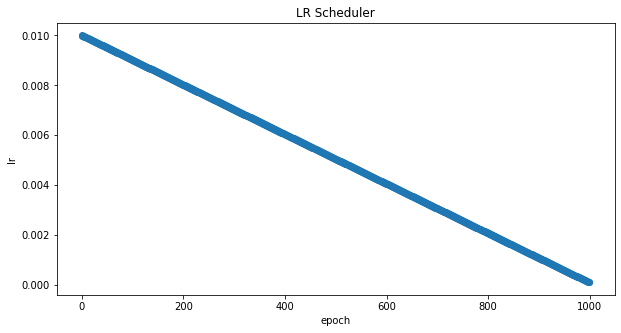

In [33]:
batch_size = 512
lr_mode = 'line'
epochs = 1000 
lr_cb = get_lr_callback(batch_size, mode=lr_mode, epochs=epochs, plot=True)

In [47]:
def split_series(series, n_past, n_future):
    X, y = [], []
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        X.append(series[window_start:past_end, :])
        y.append(series[past_end:future_end, :])
    return np.array(X), np.array(y)

n_future = 16
n_past = scaled_validation_samples.shape[0] - n_future
n_features = num_stores_train * num_families_train

X_train, y_train = split_series(scaled_train_samples, n_past, n_future)
X_val, y_val = split_series(scaled_validation_samples, n_past, n_future)

model = Sequential()
model.add(layers.LSTM(units=200, return_sequences=True, input_shape=(n_past, n_features)))
model.add(layers.BatchNormalization())
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.LSTM(units=300, return_sequences=True))
model.add(layers.BatchNormalization())
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.LSTM(units=300, return_sequences=True))
model.add(layers.BatchNormalization())
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.LSTM(units=300, return_sequences=True))
model.add(layers.BatchNormalization())
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.SeparableConv1D(filters=1000, kernel_size=(n_past - n_future + 1)))
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.SeparableConv1D(filters=1000, kernel_size=(n_past - n_future + 1), padding='same'))
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.SeparableConv1D(filters=1000, kernel_size=(n_past - n_future + 1), padding='same'))
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.TimeDistributed(layers.Dense(n_features)))

model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['msle'])

model.summary()

early_stopping = EarlyStopping(monitor='val_msle', min_delta=1e-5, patience=100, restore_best_weights=True)

model_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=[lr_cb, early_stopping], 
                          batch_size=batch_size, shuffle=False)

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_78 (LSTM)                  │ (None, 69, 200)        │     1,586,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_78          │ (None, 69, 200)        │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_12            │ (None, 69, 200)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_79 (LSTM)                  │ (None, 69, 300)        │       601,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_79          │ (None, 69, 300)        │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_13            │ (None, 69, 300)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_80 (LSTM)                  │ (None, 69, 300)        │       721,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_80          │ (None, 69, 300)        │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_14            │ (None, 69, 300)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_81 (LSTM)                  │ (None, 69, 300)        │       721,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_81          │ (None, 69, 300)        │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_15            │ (None, 69, 300)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv1d_4              │ (None, 16, 1000)       │       317,200 │
│ (SeparableConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_16            │ (None, 16, 1000)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv1d_5              │ (None, 16, 1000)       │     1,055,000 │
│ (SeparableConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_17            │ (None, 16, 1000)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv1d_6              │ (None, 16, 1000)       │     1,055,000 │
│ (SeparableConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_18            │ (None, 16, 1000)       │             0 │
│ (SpatialDropout1D)              │                        │             

 Total params: 7,845,382 (29.93 MB)

 Trainable params: 7,843,182 (29.92 MB)

 Non-trainable params: 2,200 (8.59 KB)

Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step - loss: 0.1437 - msle: 0.0342 - val_loss: 0.1220 - val_msle: 0.0178 - learning_rate: 0.0100
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - loss: 0.1252 - msle: 0.0174 - val_loss: 0.1296 - val_msle: 0.0203 - learning_rate: 0.0100
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - loss: 0.1491 - msle: 0.0243 - val_loss: 0.1486 - val_msle: 0.0276 - learning_rate: 0.0100
Epoch 4/1000


2024-07-31 13:50:11.552324: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 310210560 bytes after encountering the first element of size 310210560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - loss: 0.4305 - msle: 0.0950 - val_loss: 0.4148 - val_msle: 0.0730 - learning_rate: 0.0100
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - loss: 0.7015 - msle: 0.1441 - val_loss: 0.2398 - val_msle: 0.0410 - learning_rate: 0.0100
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - loss: 1.1409 - msle: 0.2653 - val_loss: 3.2972 - val_msle: 0.7268 - learning_rate: 0.0100
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 6s/step - loss: 2.9169 - msle: 0.8017 - val_loss: 0.6440 - val_msle: 0.0878 - learning_rate: 0.0099
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - loss: 1.8949 - msle: 0.4486 - val_loss: 3.6827 - val_msle: 1.1076 - learning_rate: 0.0099
Epoch 9/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - loss: 18.5777 - msle: 3.3864 - val_loss: 4.4548 - val_msle: 0.9740 - learning_rate: 0.0099
Epoch 10/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - loss: 5.1475 - msle: 1.2494 - val_loss: 23.9691 - val_msle: 4.7453 - learning_rate: 0.0099
Epoch 11/1000
3/

2024-07-31 13:57:46.814586: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 310210560 bytes after encountering the first element of size 310210560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 5s/step - loss: 0.0958 - msle: 0.0115 - val_loss: 0.2225 - val_msle: 0.0322 - learning_rate: 0.0097
Epoch 32/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - loss: 0.0928 - msle: 0.0110 - val_loss: 0.2270 - val_msle: 0.0341 - learning_rate: 0.0097
Epoch 33/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 5s/step - loss: 0.0906 - msle: 0.0109 - val_loss: 0.2618 - val_msle: 0.0378 - learning_rate: 0.0097
Epoch 34/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - loss: 0.0903 - msle: 0.0108 - val_loss: 0.1795 - val_msle: 0.0284 - learning_rate: 0.0097
Epoch 35/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - loss: 0.0878 - msle: 0.0106 - val_loss: 0.1587 - val_msle: 0.0264 - learning_rate: 0.0097
Epoch 36/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - loss: 0.0877 - msle: 0.0107 - val_loss: 0.1677 - val_msle: 0.0270 - learning_rate: 0.0097
Epoch 37/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - loss: 0.0860 - msle: 0.0105 - val_loss: 0.1870 - val_msle: 0.0286 - learning_rate: 0.0096
Epoch 38/1000

In [48]:
x_test_pred = scaled_validation_samples[-n_past:].reshape((1, n_past, n_features))
scaled_y_predict = model.predict(x_test_pred)

y_predict = pd.DataFrame(minmax_scaler.inverse_transform(scaled_y_predict.reshape((n_future, n_features))), columns=valid_samples_df.columns)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


In [49]:
pivoted_test = test_data.pivot(index=['date','dcoilwtico','dayofweek'], columns=['store_nbr', 'family'], values='id')

for day_ith, day_ith_pred in y_predict.iterrows():
    for n_samples_per_day in range(len(day_ith_pred)):
        sample_id = pivoted_test.iloc[[day_ith], [n_samples_per_day]].values[0][0]
        values = max(0, day_ith_pred.values[n_samples_per_day])
        submission.at[sample_id, 'sales'] = max(0, day_ith_pred.values[n_samples_per_day])

submission.to_csv('submission.csv')
print("\nFirst 5 rows of the data:")
print(submission.head())


First 5 rows of the data:
               sales
id                  
3000888     5.119675
3000889     0.026587
3000890     3.812581
3000891  1688.847412
3000892     0.516341
